In [59]:
import pandas as pd
import numpy as np

%matplotlib inline
%pylab inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, vstack

import xlwt

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('raw_data_with_labels.csv')
df = df[df['y'].notnull()] # only column with label

In [3]:
# delete raw "line" that contains empty space or null 
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0                     0
watch-title                    0
y                              0
watch-view-count               0
watch-time-text                0
content_watch-info-tag-list    0
watch7-headline                0
watch7-user-header             0
watch8-sentiment-actions       0
og:image                       0
og:image:width                 0
og:image:height                0
og:description                 0
og:video:width                 0
og:video:height                0
og:video:tag                   0
channel_link_0                 0
dtype: int64

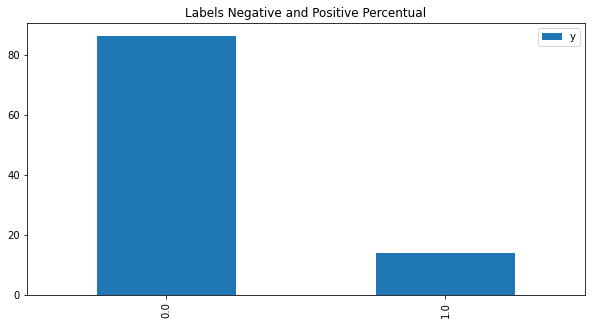

In [4]:
# Percentual negative and positive
percent = df['y'].value_counts()/df.shape[0]*100
percent.plot(kind='bar', figsize=(10,5), title='Labels Negative and Positive Percentual',
legend=True)

## Data Cleaner
    First of all chose the columns will be a possible feature
    Data cleaner with regex from python "Import re"
       create a new column with data get with re
       transform string to datetime
##### possible features to convert
    [watch-time-text], [watch-view-count], [watch-title], [watch8-sentiment-actions]

In [5]:
df_clean = pd.DataFrame(index=df.index)
df_clean['title'] = df['watch-title'].copy()

In [6]:
# # regex was a better way to get data
# we need input the number 0 because a date format
clean_date = df['watch-time-text'].str.extract(r'(\d+) de (\w+). de (\d+)')
clean_date[0] = clean_date[0].map(lambda x:  '0'+x[0] if len(str(x)) == 1 else x)

# defaut datetime is in english format, then the text is in portuguese
# let's change from Portuguese to English
month_map = {
    'jan':'Jan',
    'fev':'Feb',
    'mar':'Mar',
    'abr':'Apr',
    'mai':'May',
    'jun':'Jun',
    'jul':'Jul',
    'ago':'Aug',
    'set':'Sep',
    'out':'Oct',
    'nov':'Nov',
    'dez':'Dec'
}

clean_date[1] = clean_date[1].replace(month_map) # change to English
clean_date = clean_date.apply(lambda x: ' '.join(x), axis=1)
df_clean['date'] = pd.to_datetime(clean_date, format='%d %b %Y') # change format to datetime

In [7]:
df_clean['views'] = df['watch-view-count'].str.extract(r'(\d+\.?\d*\.?\d*)', expand=False)
df_clean['views'] = df_clean['views'].str.replace('.', '').fillna(0).astype(int)

In [8]:
df_clean.head()

,title,date,views
0,How to Become A Machine Learning Engineer | Ho...,2018-09-03,28028
1,BLOOPERS - Behind The Scenes. | DATA SCIENCE x...,2018-11-16,1131
2,Michael I. Jordan: Machine Learning: Dynamical...,2019-05-02,1816
3,Best Deep Learning Tools - Welcome.AI,2019-08-13,1171
4,Kaggle Live-Coding: RNNs for Sarcasm Detection...,2018-11-30,1228


In [9]:
features = pd.DataFrame(index=df.index)
y = df['y'].copy()

In [10]:
# for while to efect of data comparation left the same date to compare models
# when you chose the model change to this to get the actually datetime
# features['pub_time'] = (pd.datetime.now() - df_clean['date'])/np.timedelta64(1, 'D') 
features['pub_time'] = (pd.to_datetime('2020-02-23') - df_clean['date'])/np.timedelta64(1, 'D')
features['views'] = df_clean['views'].copy()
features['views_per_day'] = features['views']/features['pub_time']
features.drop('pub_time', axis=1, inplace=True)

In [11]:
# filter and split train and test validation around 50% for
mask_train = df_clean['date'] <= '2019-04-30'
mask_val = df_clean['date'] > '2019-04-30'
mask_train.shape, mask_train.shape

((436,), (436,))

In [15]:
Xtrain, Xval = features[mask_train], features[mask_val]
ytrain, yval = y[mask_train], y[mask_val]
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((230, 2), (206, 2), (230,), (206,))

In [16]:
# get the count text from title with features_extration.text from sklearn
title_train = df_clean[mask_train]['title']
title_val = df_clean[mask_val]['title']

title_vec = TfidfVectorizer(min_df=2, encoding='string') # min_df=2 mean that if frequence of words will be up of 1, or minimum 2 frequences
title_bow_train = title_vec.fit_transform(title_train) # bow = bag of words
title_bow_val = title_vec.transform(title_val)
title_bow_train.shape, title_bow_val.shape

((230, 186), (206, 186))

In [17]:
title_bow_train

<230x186 sparse matrix of type '<class 'numpy.float64'>'
	with 1279 stored elements in Compressed Sparse Row format>

In [19]:
1-1279/(230*186) # in this case total of elements is 86*84 with '0' number, and 438-1 is the without '0'
# this result 93.9% is '0' is sparse because of '0'

0.9701028517999065

In [20]:
# used scipy.sparse with hstack and vstack

Xtrain_wtitle = hstack([Xtrain, title_bow_train])
Xval_wtitle = hstack([Xval, title_bow_val])

Xtrain_wtitle.shape, Xval_wtitle.shape

((230, 188), (206, 188))

In [21]:
# mdl = DecisionTreeClassifier(random_state=0, max_depth=500, class_weight='balanced')
# mdl.fit(Xtrain_wtitle, ytrain)

mdl = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced', n_jobs=6)
mdl.fit(Xtrain_wtitle, ytrain)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=6,
                       random_state=0)

In [22]:
proba = mdl.predict_proba(Xval_wtitle)[:, 1]
target = mdl.predict(Xval_wtitle)

# scores

In [23]:
average_precision_score(yval, proba)

0.200042296082866

In [24]:
roc_auc_score(yval, proba)

0.618679775280899

In [25]:
average_precision_score(yval, target)

0.13592233009708737

In [26]:
roc_auc_score(yval, target)

0.4943820224719101

# Active Learning
    * 100 unlabeled
        * 70 frontier probability 0.45 - 0.55 *confused
        * 30 random labeled

In [29]:
df_unlabeled = pd.read_csv('raw_data_with_labels.csv', index_col=0)

In [31]:
# search only unlabeled y='null'
df_unlabeled = df_unlabeled[df_unlabeled['y'].isnull()].dropna(how='all') 
df_unlabeled.shape

(674, 16)

In [32]:
df_clean_u = pd.DataFrame(index=df_unlabeled.index)
df_clean_u['title'] = df_unlabeled['watch-title'].copy()

In [33]:
# # regex was a better way to get data
# we need input the number 0 because a date format
clean_date_u = df_unlabeled['watch-time-text'].str.extract(r'(\d+) de (\w+). de (\d+)')
clean_date_u[0] = clean_date_u[0].map(lambda x:  '0'+x[0] if len(str(x)) == 1 else x)

# defaut datetime is in english format, then the text is in portuguese
# let's change from Portuguese to English
month_map = {
    'jan':'Jan',
    'fev':'Feb',
    'mar':'Mar',
    'abr':'Apr',
    'mai':'May',
    'jun':'Jun',
    'jul':'Jul',
    'ago':'Aug',
    'set':'Sep',
    'out':'Oct',
    'nov':'Nov',
    'dez':'Dec'
}

clean_date_u[1] = clean_date_u[1].replace(month_map) # change to English
clean_date_u.dropna(inplace=True)
clean_date_u = clean_date_u.apply(lambda x: ' '.join(x), axis=1)
df_clean_u['date'] = pd.to_datetime(clean_date_u, format='%d %b %Y') # change format to datetime

In [34]:
view = df_unlabeled['watch-view-count'].str.extract(r'(\d+\.?\d*\.?\d*)', expand=False)
df_clean_u['views'] = view.str.replace('.', '').fillna(0).astype(int)

In [35]:
df_clean_u.head()

,title,date,views
501,Kaggle Mercari Price Suggestion Challenge (1 p...,2018-11-02,2167
502,OpenAI Gym and Python for Q-learning - Reinfor...,2018-10-14,20378
503,"Dashboarding with Notebooks, Day 1: What infor...",2018-12-17,10435
504,How To Get US- American Company H1 Visa To Get...,2019-11-23,7
505,Platform Overview - Machine Learning,2019-05-21,4298


In [36]:
features_u = pd.DataFrame(index=df_clean_u.index)
#y_u = df_unlabeled['y'].copy()

In [37]:
# for while to efect of data comparation left the same date to compare models
# when you chose the model change to this to get the actually datetime
# features['pub_time'] = (pd.datetime.now() - df_clean['date'])/np.timedelta64(1, 'D') 
features_u['pub_time'] = (pd.to_datetime('2020-02-23') - df_clean_u['date'])/np.timedelta64(1, 'D')
features_u['views'] = df_clean_u['views'].copy()
features_u['views_per_day'] = features_u['views']/features_u['pub_time']
features_u.drop('pub_time', axis=1, inplace=True)
features_u.fillna(0, inplace=True)
features_u.isnull().sum()

views            0
views_per_day    0
dtype: int64

In [38]:
df_clean_u.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 501 to 1183
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   title   674 non-null    object        
 1   date    674 non-null    datetime64[ns]
 2   views   674 non-null    int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 18.4+ KB


In [39]:
title_bow_u = title_vec.transform(df_clean_u['title'].values.astype('U')) 
# convert format to Unicode, because a error unicode.

title_bow_u

<674x186 sparse matrix of type '<class 'numpy.float64'>'
	with 3057 stored elements in Compressed Sparse Row format>

In [40]:
1-6037/(1551*84) # in this case total of elements is 1551*84 with '0' number, and 6037-1 is the without '0'
# this result 95.36% is '0' is sparse because of '0'

0.9536627674925547

In [41]:
# used scipy.sparse with hstack and vstack

Xu_wtitle = hstack([features_u, title_bow_u])

Xu_wtitle.shape, Xtrain_wtitle.shape, title_bow_u.shape, features_u.shape

((674, 188), (230, 188), (674, 186), (674, 2))

In [42]:
proba = mdl.predict_proba(Xu_wtitle)[:, 1]
target = mdl.predict(Xu_wtitle)

In [43]:
df_unlabeled['proba'] = proba

In [44]:
df_unlabeled.columns

Index(['watch-title', 'y', 'watch-view-count', 'watch-time-text',
       'content_watch-info-tag-list', 'watch7-headline', 'watch7-user-header',
       'watch8-sentiment-actions', 'og:image', 'og:image:width',
       'og:image:height', 'og:description', 'og:video:width',
       'og:video:height', 'og:video:tag', 'channel_link_0', 'proba'],
      dtype='object')

In [54]:
mask_u = (df_unlabeled['proba'] >= 0.27) & (df_unlabeled['proba'] <= 1.)
df_unlabeled[mask_u].shape

(67, 17)

In [63]:
fix_label = df_unlabeled[mask_u]
random_label = df_unlabeled[~mask_u].sample(100-len(fix_label))
fix_label.shape, random_label.shape

((67, 17), (33, 17))

In [67]:
pd.concat([fix_label, random_label]).to_csv('fix_and_random_label_67_17.csv')

In [70]:
df_new_label = pd.read_csv('active_labels1_done.csv', encoding='ISO-8859-1')
df_new_label.shape

(100, 18)

# scores

In [333]:
average_precision_score(yval, proba)

ValueError: Found input variables with inconsistent numbers of samples: [70, 1551]

In [43]:
roc_auc_score(yval, proba)

0.4886363636363636

In [44]:
average_precision_score(yval, target)

0.30970206264323913

In [56]:
roc_auc_score(yval, target)

0.4886363636363636